In [1]:
from qiskit.algorithms import VQE
from qiskit_nature.mappers.second_quantization import ParityMapper
from qiskit_nature.converters.second_quantization import QubitConverter
converter = QubitConverter(ParityMapper())

In [2]:
from qiskit_nature.algorithms import (GroundStateEigensolver,NumPyMinimumEigensolverFactory)

import matplotlib.pyplot as plt
import numpy as np#second_q.

from qiskit.algorithms import VQE
from qiskit_nature.algorithms import (GroundStateEigensolver,NumPyMinimumEigensolverFactory)
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import (ElectronicStructureMoleculeDriver, ElectronicStructureDriverType)
from qiskit_nature.transformers.second_quantization.electronic import FreezeCoreTransformer
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import ParityMapper


from qiskit_nature.circuit.library import UCCSD, HartreeFock
from qiskit.circuit.library import EfficientSU2
from qiskit.algorithms.optimizers import COBYLA, SPSA, SLSQP
from qiskit.opflow import TwoQubitReduction
from qiskit import BasicAer, Aer
from qiskit.utils import QuantumInstance
from qiskit.utils.mitigation import CompleteMeasFitter
from qiskit.providers.aer.noise import NoiseModel

In [3]:
def get_qubit_op(dist):
    # Define Molecule
    molecule = Molecule(
        # Coordinates in Angstrom
        geometry=[
            ["Li", [0.0, 0.0, 0.0]],
            ["H", [dist, 0.0, 0.0]]
        ],
        multiplicity=1,  # = 2*spin + 1
        charge=0,
    )

    driver = ElectronicStructureMoleculeDriver(
        molecule=molecule,
        basis="sto3g",
        driver_type=ElectronicStructureDriverType.PYSCF)

    # Get properties
    properties = driver.run()
    num_particles = (properties
                        .get_property("ParticleNumber")
                        .num_particles)
    num_spin_orbitals = int(properties
                            .get_property("ParticleNumber")
                            .num_spin_orbitals)

    # Define Problem, Use freeze core approximation, remove orbitals.
    problem = ElectronicStructureProblem(
        driver,
        [FreezeCoreTransformer(freeze_core=True,
                               remove_orbitals=[-3,-2])])

    second_q_ops = problem.second_q_ops()  # Get 2nd Quant OP
    num_spin_orbitals = problem.num_spin_orbitals
    num_particles = problem.num_particles

    mapper = ParityMapper()  # Set Mapper
    hamiltonian = second_q_ops[0]  # Set Hamiltonian
    # Do two qubit reduction
    converter = QubitConverter(mapper) #,two_qubit_reduction=True)
    #reducer = TwoQubitReduction(num_particles)
    qubit_op = converter.convert(hamiltonian)
    #qubit_op = reducer.convert(qubit_op)

    return qubit_op, num_particles, num_spin_orbitals, problem, converter

In [4]:
def exact_solver(converter,problem): #, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter,solver) #converter,
    result = calc.solve(problem)
    return result


In [5]:
distances=np.arange(0.5,4.0,0.1)
exact_energies = []
vqe_energies = []
for dist in distances:
    (qubit_op, num_particles, num_spin_orbitals,problem,converter) = get_qubit_op(dist)
    res=exact_solver(converter,problem)
    vqe_result = problem.interpret(res).total_energies[0].real
    vqe_energies.append(vqe_result)

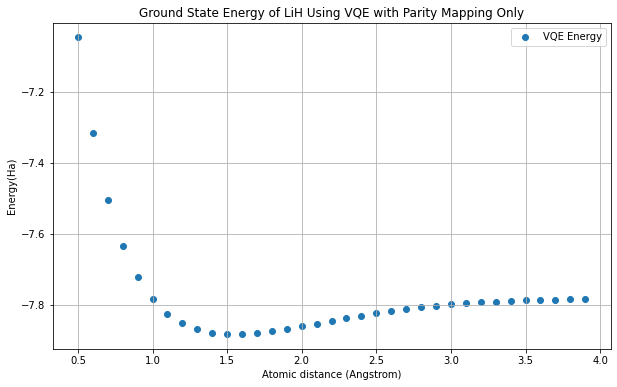

In [17]:
#plt.plot(distances, exact_energies, label="Exact Energy")
plt.figure(1,figsize=(10,6))
plt.scatter(distances, vqe_energies, label="VQE Energy")
plt.title("Ground State Energy of LiH Using VQE with Parity Mapping Only")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy(Ha)')
plt.legend()
plt.grid()
#plt.show()
plt.savefig('VQE11.pdf',dpi=500)

In [7]:
distances

array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7,
       1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. ,
       3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9])

In [8]:
vqe_energies

[-7.047909879814178,
 -7.3178406066899875,
 -7.503999888589233,
 -7.633380430851103,
 -7.722834592189438,
 -7.784021320448164,
 -7.82520275291316,
 -7.852161260058633,
 -7.868904084576936,
 -7.878230653191288,
 -7.8821399602353175,
 -7.882096599921154,
 -7.8791978711980715,
 -7.874280033933956,
 -7.867988787415271,
 -7.860828258230761,
 -7.853196249222231,
 -7.8454099164161235,
 -7.837724037354429,
 -7.830342952207782,
 -7.823426939851898,
 -7.8170942094941145,
 -7.811420600562359,
 -7.806439810199664,
 -7.802146652069217,
 -7.798504222561991,
 -7.795453823142569,
 -7.792925298736854,
 -7.790845717074498,
 -7.789145387260316,
 -7.78776126621167,
 -7.786638363119266,
 -7.785729858099107,
 -7.7849965239668935,
 -7.784405836830914]